In [ ]:
# default_exp data.mixmethods

# Mixup and Friends

In [ ]:
# hide
import warnings
from nbdev.export import *

warnings.filterwarnings('ignore')

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# export
import numpy as np
from collections import namedtuple

import torch
import torch.nn.functional as F
from torch.nn import Module

from fastcore.all import store_attr, ifnone, delegates, basic_repr
from src import _logger

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from timm.data.constants import IMAGENET_DEFAULT_MEAN as mean
from timm.data.constants import IMAGENET_DEFAULT_STD as std
from timm.data.transforms import RandomResizedCropAndInterpolation
from torchvision.utils import make_grid

from src.data.datasets import CassavaDataset, load_data

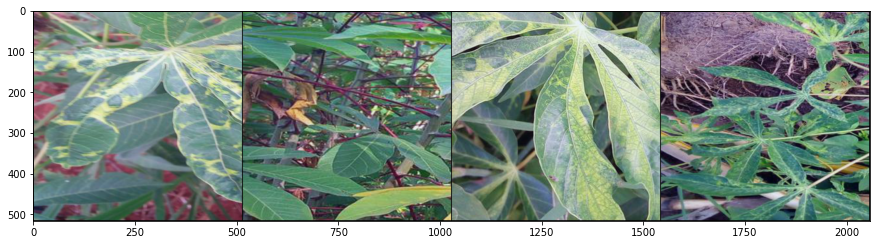

In [ ]:
t1 = T.Compose(
    [
        RandomResizedCropAndInterpolation(512, interpolation="random"),
        T.ToTensor(),
        T.Normalize(mean, std),
    ]
)

csv_path = "../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv"
imgs_dir = "../../Datasets/cassava/train_images/"
df = load_data(csv_path, imgs_dir, curr_fold=0, shuffle=True)

dset = CassavaDataset.from_torchvision_tfms(df, "filePath", label_col="label", transform=t1)
dl = torch.utils.data.DataLoader(dset, batch_size=4)

image, label = next(iter(dl))
grid = make_grid(image, normalize=True).permute(1, 2, 0).numpy()

plt.figure(figsize=(15, 10))
plt.imshow(grid);

## BasicHandler Class -

In [ ]:
# export
class BaseMixMethodHandler:
    "Base class for implementing `MixUp` style transforms to a `batch` of data"
    _logger = _logger
    _curr_iter = 0
    _is_active, _done_logging = False, False
    _has_ended = False
    device = None

    def __init__(
        self, alpha: float = 0.5, conf_prob: float = 1.0, num_iters: int = None
    ):
        store_attr()
        if self.alpha > 0.0:
            self.distrib = np.random.beta(self.alpha, self.alpha)
        else:
            self.distrib = 1
            
    __repr__ = basic_repr("alpha,conf_prob,num_iters")

    def call(self, inputs: torch.Tensor, targets: torch.Tensor, model: Module = None):
        "logic for applying transformations to a batch"
        raise NotImplementedError

    def _check_has_ended(self):
        "check wether MixMethod has ended"
        if self.num_iters is not None:
            return self._curr_iter == self.num_iters
        else:
            return self._has_ended

    def step(self):
        "increases the count of the current iteration"
        if self.num_iters is not None:
            self._curr_iter += 1

    def stop(self):
        "stops the mixmethod from furthur activation"
        self._curr_iter = self.num_iters
        self._is_active = False
        self._has_ended = True
        self._done_logging = False

    def __call__(self, inputs: torch.Tensor, targets: torch.Tensor, model: Module = None):
        "calls function"
        store_attr()
        if self.num_iters is not None:
            if self._check_has_ended():
                self._is_active = False
            else:
                if self._curr_iter < self.num_iters:
                    outputs = self.call(inputs, targets=targets, model=model)
                    inputs, self.lam_a, self.lam_b, self.target_a, self.target_b = outputs
                else:
                    self._is_active = False

            if self._check_has_ended():
                if not self._done_logging:
                    self._logger.info(f"{self.__class__.__name__} Stopped .")
                    self._done_logging = True
                self._is_active = False

        else:
            if self._check_has_ended():
                if not self._done_logging:
                    self._logger.info(f"{self.__class__.__name__} Stopped .")
                    self._done_logging = True
                self._is_active = False
            else:
                outputs = self.call(inputs, targets=targets, model=model)
                inputs, self.lam_a, self.lam_b, self.target_a, self.target_b = outputs

        return inputs

    def _loss(self, outputs: torch.Tensor, loss_func: Module):
        "Logic for calling the `loss_func`"
        raise NotImplementedError

    def lf(self, outputs: torch.Tensor, loss_func: Module):
        "calls the `_loss` if `_is_active` or applies the vanilla `loss_func`"
        if not self._has_ended:
            if self._is_active:
                # if mixup method is_active call the custom loss function
                loss = self._loss(outputs, loss_func)
            else:
                # else call the given loss function
                loss = loss_func(outputs, self.targets)
        else:
            loss = loss_func(outputs, self.targets)
        return loss

## Mixup

In [ ]:
# export
class Mixup(BaseMixMethodHandler):
    """
    Implements mixup from https://arxiv.org/abs/1710.09412.

    Reference: https://github.com/facebookresearch/mixup-cifar10/blob/master/train.py
    """

    def call(self, inputs, targets, *args, **kwargs):
        r = np.random.rand(1)
        batch_size = inputs.size()[0]

        self.device = ifnone(self.device, self.inputs.device)

        lam_a = torch.ones(batch_size, device=self.device)

        target_a = targets
        target_b = targets

        if r < self.conf_prob:
            self._is_active = True
            rand_index = torch.randperm(batch_size, device=self.device)

            lam = self.distrib

            lam = torch.tensor(lam, device=self.device)
            inputs = lam * inputs + (1 - lam) * inputs[rand_index, :]
            target_a, target_b = targets, targets[rand_index]
            lam_a = lam_a * lam

        else:
            self._is_active = False

        lam_b = 1 - lam_a

        return inputs, lam_a, lam_b, target_a, target_b

    def _loss(self, outputs, loss_func):
        loss_a = loss_func(outputs, self.target_a)
        loss_b = loss_func(outputs, self.target_b)
        loss = torch.mean(loss_a * self.lam_a + loss_b * self.lam_b)
        return loss

Mixup(alpha=0.5, conf_prob=1.0, num_iters=None)


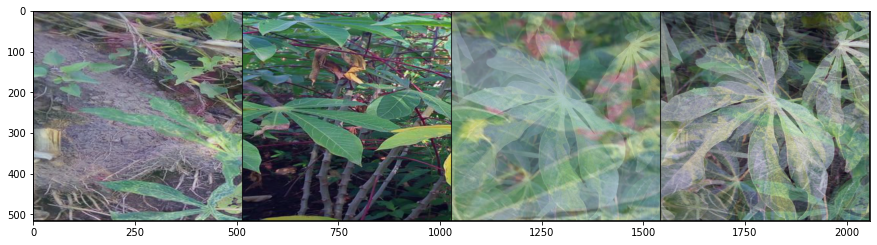

In [ ]:
# intialize mixup
mixup = Mixup(alpha=0.5, conf_prob=1.0)
_logger.info(mixup)

images, targets = next(iter(dl))
mixed_images = mixup(images, targets, model=None)


plt.figure(figsize=(15, 10))
grid = make_grid(mixed_images, normalize=True).permute(1, 2, 0).numpy()
plt.imshow(grid)

In [ ]:
# generate random outputs
random_outputs = torch.randn(targets.size()[0], 5)

criterion = torch.nn.CrossEntropyLoss()

print("Loss:", mixup.lf(random_outputs, criterion))

Loss: tensor(1.7024)


Mixup Stopped .


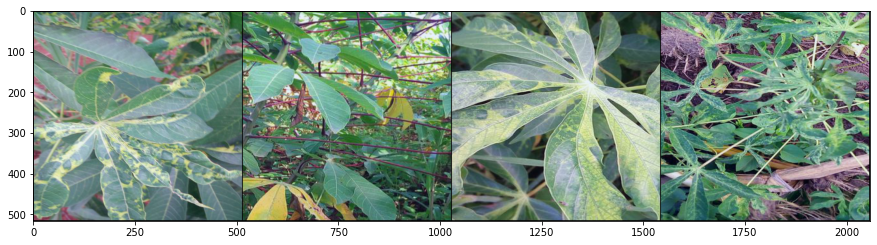

In [ ]:
mixup.stop()

images, targets = next(iter(dl))

mixed_images = mixup(images, targets, model=None)

plt.figure(figsize=(15, 10))
grid = make_grid(mixed_images, normalize=True).permute(1, 2, 0).numpy()
plt.imshow(grid)

## Cutmix

In [ ]:
# export
class Cutmix(BaseMixMethodHandler):
    """Implementation of https://arxiv.org/abs/1905.04899"""

    @delegates(BaseMixMethodHandler.__init__)
    def __init__(self, alpha=1.0, **kwargs):
        super(Cutmix, self).__init__(alpha=alpha, **kwargs)

    def rand_bbox(self, W, H, lam):
        "generates a random bbox for `Cutmix`"

        cut_rat = torch.sqrt(1.0 - lam)
        cut_w = torch.round(W * cut_rat).type(torch.long).to(self.device)
        cut_h = torch.round(H * cut_rat).type(torch.long).to(self.device)

        cx = torch.randint(0, W, (1,), device=self.device)
        cy = torch.randint(0, H, (1,), device=self.device)
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)

        return x1, y1, x2, y2

    def call(self, inputs, targets, *args, **kwargs):
        r = np.random.rand(1)
        batch_size, C, H, W = inputs.size()
        self.device = ifnone(self.device, self.inputs.device)
        lam_a = torch.ones(batch_size, device=self.device)

        target_a = targets
        target_b = targets

        if r < self.conf_prob:
            self._is_active = True

            if self.alpha > 0.0:
                lam = np.random.beta(self.alpha, self.alpha)
            else:
                lam = 1

            rand_index = torch.randperm(batch_size, device=self.device)
            lam = torch.tensor(lam, device=self.device)
            target_a, target_b = targets, targets[rand_index]

            x1, y1, x2, y2 = self.rand_bbox(W, H, lam)
            inputs[:, :, x1:x2, y1:y2] = inputs[rand_index, :, x1:x2, y1:y2]

            # adjust lambda to exactly match pixel ratio
            lam = (1 - ((x2 - x1) * (y2 - y1)) / float(W * H)).item()
            lam_a = lam_a * lam

        else:
            self._is_active = False

        lam_b = 1 - lam_a
        return inputs, lam_a, lam_b, target_a, target_b

    def _loss(self, outputs, loss_func):
        loss_a = loss_func(outputs, self.target_a)
        loss_b = loss_func(outputs, self.target_b)
        loss = torch.mean(loss_a * self.lam_a + loss_b * self.lam_b)
        return loss

## Snapmix

In [ ]:
# export
class Snapmix(BaseMixMethodHandler):
    """Implementation of https://arxiv.org/abs/2012.04846.
    
    Reference: https://github.com/Shaoli-Huang/SnapMix
    """
    
    @delegates(BaseMixMethodHandler.__init__)
    def __init__(self, alpha=5.0, **kwargs):
        super(Snapmix, self).__init__(alpha=5.0, **kwargs)
        
    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1.0 - lam)
        cut_w = torch.round(W * cut_rat).type(torch.long).to(self.device)
        cut_h = torch.round(H * cut_rat).type(torch.long).to(self.device)
        
        cx = torch.randint(0, W, (1,), device=self.device)
        cy = torch.randint(0, H, (1,), device=self.device)
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        
        return x1, y1, x2, y2
    
    def get_spm(self, inputs, targets, model):
        batch_size, C, H, W = inputs.size()
        img_size = (H, W)
        classifier = model.get_classifier()
        
        with torch.no_grad():
            fms = model.forward_features(inputs)
            # grab the classification layer of the model
            clsw = model.get_classifier()
            
            weight = clsw.weight.data
            weight = weight.view(weight.size(0), weight.size(1), 1, 1)
            bias = clsw.bias.data
            
            fms = F.relu(fms)
            poolfea = F.adaptive_avg_pool2d(fms, (1, 1)).squeeze()
            clslogit = F.softmax(clsw.forward(poolfea))
            
            logitlist = []
            
            for i in range(batch_size):
                logitlist.append(clslogit[i, targets[i]])
                
            clslogit = torch.stack(logitlist)
            out = F.conv2d(fms, weight, bias=bias)
            
            outmaps = []
            
            for i in range(batch_size):
                evimap = out[i, targets[i]]
                outmaps.append(evimap)
                
            outmaps = torch.stack(outmaps)
            outmaps = outmaps.view(outmaps.size(0), 1, outmaps.size(1), outmaps.size(2))
            outmaps = F.interpolate(outmaps, img_size, mode="bilinear", align_corners=False)
            outmaps = outmaps.squeeze()
            
            for i in range(batch_size):
                outmaps[i] -= outmaps[i].min()
                outmaps[i] /= outmaps[i].sum()
            
            return outmaps, clslogit

        
    def call(self, inputs, targets, model):
        """For `Snapmix` a `model` must be passed & the `model` should have `get_classifier` method
        and a `forward_features` method.
        """
        assert model is not None, "Snapmix is not possible without model"
        
        r = np.random.rand(1)
        batch_size, C, H, W = inputs.size()
        self.device = ifnone(self.device, self.inputs.device)
        
        lam_a = torch.ones(batch_size, device=self.device)
        lam_b = 1 - lam_a
        
        target_a = targets
        target_b = targets
        
        if r < self.conf_prob:
            self._is_active = True
            wfmaps,_ = self.get_spm(inputs, targets, model=model)
            
            if self.alpha > 0. :
                lam  = np.random.beta(self.alpha, self.alpha)
                lam1 = np.random.beta(self.alpha, self.alpha)
            else:
                lam  = 1
                lam1 = np.random.beta(self.alpha, self.alpha)
            
            rand_index = torch.randperm(batch_size, device=self.device)
            lam  = torch.tensor(lam, device=self.device)
            lam1 = torch.tensor(lam1, device=self.device)
            
            wfmaps_b = wfmaps[rand_index,:,:]
            target_b = targets[rand_index]
            
            same_label = targets == target_b
            bbx1, bby1, bbx2, bby2 = self.rand_bbox(W, H, lam)
            bbx1_1, bby1_1, bbx2_1, bby2_1 = self.rand_bbox(W, H, lam1)
            
            area = (bby2-bby1)*(bbx2-bbx1)
            area1 = (bby2_1-bby1_1)*(bbx2_1-bbx1_1)
            
            if  area1 > 0 and  area>0:
                ncont = inputs[rand_index, :, bbx1_1:bbx2_1, bby1_1:bby2_1].clone()
                ncont = F.interpolate(ncont, size=(bbx2-bbx1,bby2-bby1), mode='bilinear', align_corners=True)
                inputs[:, :, bbx1:bbx2, bby1:bby2] = ncont
                lam_a = 1 - wfmaps[:,bbx1:bbx2,bby1:bby2].sum(2).sum(1)/(wfmaps.sum(2).sum(1)+1e-8)
                lam_b = wfmaps_b[:,bbx1_1:bbx2_1,bby1_1:bby2_1].sum(2).sum(1)/(wfmaps_b.sum(2).sum(1)+1e-8)
                tmp = lam_a.clone()
                lam_a[same_label] += lam_b[same_label]
                lam_b[same_label] += tmp[same_label]
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
                lam_a[torch.isnan(lam_a)] = lam
                lam_b[torch.isnan(lam_b)] = 1-lam
        else:
            self._is_active = False
        
        return inputs, lam_a, lam_b, target_a, target_b
    
    def _loss(self, outputs, loss_func):
        loss_a = loss_func(outputs, self.target_a)
        loss_b = loss_func(outputs, self.target_b)
        loss = torch.mean(loss_a*self.lam_a + loss_b*self.lam_b)
        return loss

In [ ]:
# hide
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.datasets.ipynb.
Converted 01a_data.mixmethods.ipynb.
Converted 01b_data.datasests_factory.ipynb.
Converted 02_losses.ipynb.
Converted 03_models.utils.ipynb.
Converted 03a_models.builder.ipynb.
Converted 03a_models.layers.ipynb.
Converted 03b_models.classifiers.ipynb.
Converted 04_optimizers.ipynb.
Converted 04a_schedulers.ipynb.
Converted 05a_lightning.core.ipynb.
Converted 05b_lightning.callbacks.ipynb.
Converted 05c_lightning.callbacks.progress.ipynb.
Converted 06_fastai.core.ipynb.
Converted index.ipynb.
